# Summary

This notebook explores unsupervised learning techniques on the DBPedia dataset. We'll analyze text data using NLP preprocessing, dimensionality reduction with PCA, and visualization techniques to uncover patterns and clusters in the data without using labels.


# Dependencies

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from datasets import load_dataset


/Users/seanbaier/Documents/projects/mscs/Courses/machine-learning/machine-learning-2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Raw Data

In [29]:
dataset = load_dataset('dbpedia_14')
# Using a small subset of the data for faster training
df_train_small = dataset['train'].shuffle(seed=42).select(range(5000))
df_test_small = dataset['test'].shuffle(seed=42).select(range(1000))

df_train = pd.DataFrame(df_train_small)
df_test = pd.DataFrame(df_test_small)

In [30]:
# rename columns
df_train = df_train.rename(columns={'content': 'Text', 'label': 'Category'})
df_test = df_test.rename(columns={'content': 'Text', 'label': 'Category'})

In [31]:
# Display data info
print(df_train.head())
print("\n Info: \n")
df_train.info()

   Category                         title  \
0         0               Sparebanken NOR   
1         0  American Letter Mail Company   
2        11    Corridors of Power (album)   
3         8                 Kanni Banmauk   
4        12          Zombie Hunter (film)   

                                                Text  
0   Union Bank of Norway branded as Sparebanken N...  
1   The American Letter Mail Company was started ...  
2   Corridors of Power is the third solo album by...  
3   Kanni is a village in Banmauk Township Katha ...  
4   Zombie Hunter is a 2013 American direct-to-vi...  

 Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5000 non-null   int64 
 1   title     5000 non-null   object
 2   Text      5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [32]:
print(df_test.head())
print("\n Info: \n")
df_test.info()

   Category                                              title  \
0        13                                    The April Witch   
1         6                         Blackinton Houses and Park   
2         1  Pope John XXIII High School (Everett Massachus...   
3         5                Kaiserliche Werft Wilhelmshaven 401   
4         9                            Periscepsia handlirschi   

                                                Text  
0   The April Witch is a fantasy short story by R...  
1   Blackinton Houses and Park is a historic site...  
2   Pope John XXIII High School is a private Roma...  
3   Imperian German Navy seaplanes numbers 401 to...  
4   Periscepsia handlirschi is a species of fly i...  

 Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  1000 non-null   int64 
 1   title     1000 non-null   object
 2   T

## Exploratory Data Analisys (EDA)

### Data Overview and Cleaning

- The data consists of Wikipedia abstracts labeled by ontology class (e.g., Company, Artist, Place, etc.).
- First, we load both train and test datasets for inspection.
- We check for missing/null values and clean any if needed.
- We visualize class balance—if it's imbalanced, we might need to adjust modeling later.

Category    0
title       0
Text        0
dtype: int64


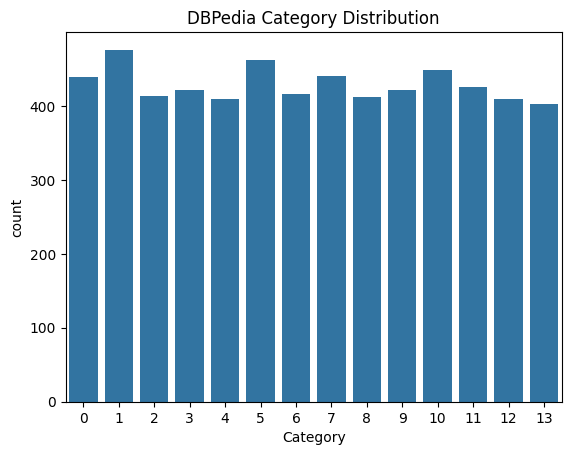

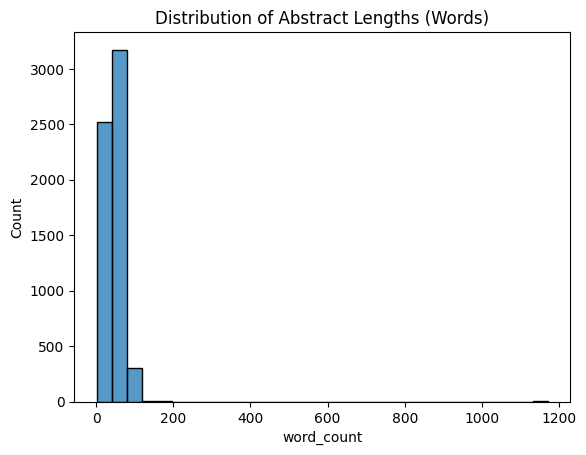

In [33]:
df = pd.concat([df_train, df_test], ignore_index=True)

# Check for missing values
print(df.isnull().sum())

# Visualize class distribution
sns.countplot(x='Category', data=df)
plt.title("DBPedia Category Distribution")
plt.show()

# Article length in words
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['word_count'], bins=30)
plt.title('Distribution of Abstract Lengths (Words)')
plt.show()

### Data Cleaning

- Lowercasing text
- Removing punctuation and numbers
- Removing stopwords (common words with little meaning, e.g., "the", "and")
- Lemmatizing

In [34]:
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_md")

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words_ = word_tokenize(text)

    doc = nlp(' '.join(words_))
    lemmas = [x.lemma_ for x in doc]
    lemmas = [l for l in lemmas if l not in stop_words and l.isalpha()]

    cleaned_text = ' '.join(lemmas)
    return cleaned_text

clean_train_data = df_train['Text'].apply(clean_text)
clean_test_data = df_test['Text'].apply(clean_text)

print(clean_train_data.head())


0    union bank norway brand sparebanken norway lar...
1    american letter mail company start lysander sp...
2    corridor power third solo album irish guitaris...
3    kanni village banmauk township katha district ...
4    zombie hunter american directtovideo actionthr...
Name: Text, dtype: object


/var/folders/l2/jl8p3_b97qd5g54qcjcv_q7c0000gn/T/ipykernel_7158/1088945506.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='mako')


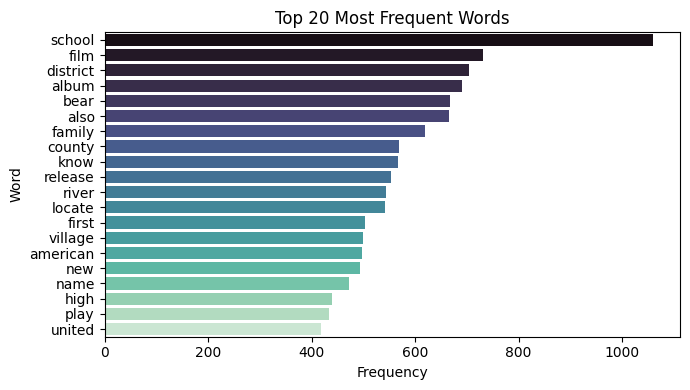

In [35]:
from collections import Counter

all_words = ' '.join(clean_train_data).split()
common_words = Counter(all_words).most_common(20)
words, counts = zip(*common_words)

plt.figure(figsize=(7,4))
sns.barplot(x=list(counts), y=list(words), palette='mako')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

## PCA Unsupervised Matrix Factorization

In [36]:
nlp = spacy.load("en_core_web_md")

def spacy_doc_vector(text):
    doc = nlp(text)
    vectors = [token.vector for token in doc if token.has_vector]
    if not vectors:
        return np.zeros(nlp.vocab.vectors_length)
    return np.mean(vectors, axis=0)

df_train['spacy_vector'] = clean_train_data.apply(spacy_doc_vector)
df_test['spacy_vector'] = clean_test_data.apply(spacy_doc_vector)

In [37]:
X_train = np.vstack(df_train['spacy_vector'].values)
X_test = np.vstack(df_test['spacy_vector'].values)

### Matrix Factorization Model: PCA

PCA is used to reduce dimensionality of the spaCy word vectors and identify principal components as topics. Each abstract is assigned to its highest-scoring component, which is then mapped to a real category.

In [40]:
num_components = 14  # DBPedia has 14 ontology classes
pca = PCA(n_components=num_components, random_state=42)
W_train = pca.fit_transform(X_train)
W_test = pca.transform(X_test)

In [41]:
# Assign component topic with the largest value
y_train_pred = np.argmax(W_train, axis=1)
y_test_pred = np.argmax(W_test, axis=1)

# Map components to true labels
le = LabelEncoder()
y_train_true = le.fit_transform(df_train['Category']) # only on training data

In [42]:
# Find the most common true label in each component/topic
component_label_map = {}
for component in range(num_components):
    idx = np.where(y_train_pred == component)[0]
    if len(idx) == 0:
        component_label_map[component] = -1
        continue
    most_common = np.bincount(y_train_true[idx]).argmax()
    component_label_map[component] = most_common

# Map predictions to true labels
y_train_pred_mapped = [component_label_map[c] for c in y_train_pred]
y_test_pred_mapped = [component_label_map[c] for c in y_test_pred]

In [43]:
# Evaluate
train_acc = accuracy_score(y_train_true, y_train_pred_mapped) # training data only
print(f"PCA (Unsupervised) Train Accuracy: {train_acc:.3f}")

cm = confusion_matrix(y_train_true, y_train_pred_mapped)
print("Confusion Matrix (Train):")
print(cm)

PCA (Unsupervised) Train Accuracy: 0.335
Confusion Matrix (Train):
[[228   0   0  13   9  10   5   0  40   0   6  22  10   8]
 [165   0   0  70  29   0   5   0  76   0   1   7  16  24]
 [ 49   0   0  83  26  12  21   0   0   0   4  31  95  16]
 [ 19   0   0 245  29   6   0   0   1   0   0   3  51   4]
 [ 21   0   0  68  49   2  16   0  65   0   0   1  44  62]
 [159   0   0  45  30  30   4   0  42   0  26  15  33  14]
 [153   0   0  54  17   7  24   0  76   0   6  14  14   0]
 [ 22   0   0  42  27  22   6   0 189   0  22   4  27   0]
 [  1   0   0   1   8   0   7   0 330   0   1   3  13   0]
 [  4   0   0   5  16   7   0   0   2   0 275  11  20  13]
 [  6   0   0   9   9   9   9   0   6   0 304   7  11   0]
 [138   0   0   6   0   1   7   0   0   0   4 174  38   0]
 [ 29   0   0  35  15   3   9   0   0   0   0  12 226   5]
 [117   0   0  17   5   1  12   0   4   0   6  13  81  64]]


In [46]:
# Assign pseudo-labels for the test set
y_test_pred_mapped = [component_label_map[c] for c in y_test_pred]

# Decode integer predictions to category labels for test set output
category_names = le.inverse_transform(list(range(num_components)))
predicted_labels_test = [category_names[c] if c >= 0 and c < len(category_names) else "unknown" for c in y_test_pred_mapped]

# Save test set predictions to CSV (for submission/review)
df_test['Predicted_Category'] = predicted_labels_test
df_test[['Text', 'Predicted_Category']].to_csv('dbpedia_test_set_predictions.csv', index=False)

## Supervised Learning Comparison

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Use only training data
X = X_train
y = y_train_true

X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, train_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_split, y_train_split)

y_pred_lr = lr.predict(X_val)
y_test_pred_lr = lr.predict(X_test)

# Gaussian Naive Bayes
nb = GaussianNB()
nb.fit(X_train_split, y_train_split)

y_pred_nb = nb.predict(X_val)
y_test_pred_nb = nb.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_split, y_train_split)

y_pred_rf = rf.predict(X_val)
y_test_pred_rf = rf.predict(X_test)

print("PCA (Unsupervised) Accuracy:", accuracy_score(y_val, y_pred_rf))
print("LogReg Accuracy:", accuracy_score(y_val, y_pred_lr))
print("NB Accuracy:", accuracy_score(y_val, y_pred_nb))
print("RF Accuracy:", accuracy_score(y_val, y_pred_rf))

PCA (Unsupervised) Accuracy: 0.75675
LogReg Accuracy: 0.845
NB Accuracy: 0.715
RF Accuracy: 0.75675


## Conclusion

- The unsupervised PCA and the Random Forest were pretty simialar in accuracy. However the Linear Regression supervised model was more effective for text classification with 0.845 accuracy.

- Future improvements could include experimenting with more advanced embeddings (e.g., BERT), hyperparameter tuning, and deeper analysis of misclassified examples.


## References:

- [scikit-learn documentation](https://scikit-learn.org/stable/documentation.html)
- [NumPy documentation](https://numpy.org/doc/stable/)
- [Pandas documentation](https://pandas.pydata.org/docs/)
- [Matplotlib documentation](https://matplotlib.org/stable/contents.html)
- [Seaborn documentation](https://seaborn.pydata.org/documentation.html)
- [spaCy documentation](https://spacy.io/usage)
- [HuggingFace Datasets](https://huggingface.co/datasets/dbpedia_14)